Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
import pickle
import ipywidgets as widgets
from IPython.display import display, HTML
import time

In [2]:
ROWS = 6
COLS = 7
WIN_REWARD = 10
LOSS_PENALTY = -10
THREE_IN_ROW_REWARD = 1
MISS_BLOCK_PENALTY = -3
MISS_WIN_PENALTY = -3

In [30]:
class Connect4Env:
    def __init__(self):
        self.board = np.zeros((ROWS, COLS), dtype=int)
        self.current_player = 1
        self.rows = ROWS
        self.cols = COLS

    def reset(self):
        self.board = np.zeros((ROWS, COLS), dtype=int)
        self.current_player = 1
        return self.board.flatten()

    def available_moves(self):
        return [c for c in range(COLS) if self.board[0, c] == 0]

    def make_move(self, col):
        if col not in self.available_moves():
            return False
        for row in range(ROWS-1, -1, -1):
            if self.board[row, col] == 0:
                self.board[row, col] = self.current_player
                break
        self.switch_player()  # Automatically switch after a valid move
        return True

    def switch_player(self):
        self.current_player = -1 if self.current_player == 1 else 1

    def check_winner(self):
        """
        Check the board for a winner:
        - Returns 1 if player 1 wins.
        - Returns -1 if player 2 wins.
        - Returns 0 if there is a draw.
        - Returns None if the game is not finished.
        """
        # Horizontal Check
        for r in range(ROWS):
            for c in range(COLS - 3):
                if abs(self.board[r, c]) == 1 and len(set(self.board[r, c:c + 4])) == 1:
                    return self.board[r, c]

        # Vertical Check
        for c in range(COLS):
            for r in range(ROWS - 3):
                if abs(self.board[r, c]) == 1 and len(set(self.board[r:r + 4, c])) == 1:
                    return self.board[r, c]

        # Diagonal (Down-Right)
        for r in range(ROWS - 3):
            for c in range(COLS - 3):
                if abs(self.board[r, c]) == 1 and all(self.board[r + i, c + i] == self.board[r, c] for i in range(4)):
                    return self.board[r, c]

        # Diagonal (Up-Right)
        for r in range(3, ROWS):
            for c in range(COLS - 3):
                if abs(self.board[r, c]) == 1 and all(self.board[r - i, c + i] == self.board[r, c] for i in range(4)):
                    return self.board[r, c]

        # If there are no moves left and no winner, it's a draw
        if len(self.available_moves()) == 0:
            return 0
        
        return None

    def get_state(self):
        return self.board.flatten()

    def render(self):
        print(np.flip(self.board, 0))
        
    def step(self, col):
        """
        Apply the move to the board and return:
        - next_state: the board state after the move
        - reward: the reward for the move
        - done: if the game is over
        - info: extra information (empty for now)
        """
        if not self.make_move(col):
            return self.get_state(), -1, True, {}  # Invalid move
        
        winner = self.check_winner()
        
        if winner == 1:
            return self.get_state(), WIN_REWARD, True, {}
        elif winner == -1:
            return self.get_state(), LOSS_PENALTY, True, {}
        elif winner == 0:
            return self.get_state(), 0, True, {}
        
        # If no one won, just return the current state with no reward
        return self.get_state(), 0, False, {}

    def count_threes(self, player):
        count = 0
        for r in range(ROWS):
            for c in range(COLS - 2):
                if np.all(self.board[r, c:c + 3] == player):
                    count += 1
        for r in range(ROWS - 2):
            for c in range(COLS):
                if np.all(self.board[r:r + 3, c] == player):
                    count += 1
        for r in range(ROWS - 2):
            for c in range(COLS - 2):
                if all(self.board[r + i, c + i] == player for i in range(3)):
                    count += 1
        for r in range(2, ROWS):
            for c in range(COLS - 2):
                if all(self.board[r - i, c + i] == player for i in range(3)):
                    count += 1
        return count

In [4]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
class DQNAgent:
    def __init__(self, env, model, target_model, memory, lr=0.001, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995):
        self.env = env
        self.model = model
        self.target_model = target_model
        self.memory = memory
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def select_action(self, state, valid_actions):
        """
        Select an action for the agent:
        - If random < epsilon, choose a random valid move.
        - Otherwise, select the best Q-value move from the model.
        """
        if random.random() < self.epsilon:
            return random.choice(valid_actions)

        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)

        valid_q_values = torch.FloatTensor([-float('inf')] * COLS)
        for action in valid_actions:
            valid_q_values[action] = q_values.squeeze()[action]

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return torch.argmax(valid_q_values).item()

    def train_step(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q = self.target_model(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = self.loss_fn(current_q, target_q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [28]:
def self_play(agent1, agent2, env, episodes=1000, batch_size=32):
    metrics = {
        'episodes': [],
        'agent1_wins': [],
        'agent2_wins': [],
        'draws': [],
        'avg_rewards_1': [],
        'avg_rewards_2': []
    }

    for episode in range(episodes):
        print(f"Starting Episode {episode}")
        state = env.reset()
        done = False
        current_agent = agent1
        opponent = agent2
        agent1_rewards = 0
        agent2_rewards = 0

        while not done:
            valid_actions = env.available_moves()
            
            # Debugging Information
            if episode % 100 == 0:
                print(f"Valid Actions: {valid_actions}")
                env.render()
            
            if not valid_actions:
                done = True
                metrics['draws'].append(1)  # Add a draw if no valid moves
                metrics['agent1_wins'].append(0)
                metrics['agent2_wins'].append(0)
                print("⚠️ Draw: No valid moves")
                break

            action = current_agent.select_action(state, valid_actions)
            env.make_move(action)

            next_state = env.get_state()
            winner = env.check_winner()
            
            if winner is not None:
                print(f"🏆 Winner Detected: {winner}")
                done = True
                if winner == 1:
                    metrics['agent1_wins'].append(1)
                    metrics['agent2_wins'].append(0)
                    metrics['draws'].append(0)
                elif winner == -1:
                    metrics['agent1_wins'].append(0)
                    metrics['agent2_wins'].append(1)
                    metrics['draws'].append(0)
                else:
                    metrics['agent1_wins'].append(0)
                    metrics['agent2_wins'].append(0)
                    metrics['draws'].append(1)
            elif winner == 0:
                print("🤝 Game ended in a Draw")
                done = True
                metrics['agent1_wins'].append(0)
                metrics['agent2_wins'].append(0)
                metrics['draws'].append(1)

            state = next_state
            env.switch_player()
            current_agent, opponent = opponent, current_agent

        metrics['episodes'].append(episode)
        metrics['avg_rewards_1'].append(agent1_rewards)
        metrics['avg_rewards_2'].append(agent2_rewards)

        # Print metrics every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes} - Agent 1 Wins: {sum(metrics['agent1_wins'])}, "
                  f"Agent 2 Wins: {sum(metrics['agent2_wins'])}, Draws: {sum(metrics['draws'])}")

    return metrics

In [34]:
# Initialize environment
env = Connect4Env()

# Create models for the agents
model1 = DQN(input_dim=ROWS * COLS, output_dim=COLS)
model2 = DQN(input_dim=ROWS * COLS, output_dim=COLS)

# Create target networks
target_model1 = DQN(input_dim=ROWS * COLS, output_dim=COLS)
target_model2 = DQN(input_dim=ROWS * COLS, output_dim=COLS)

# Initialize the replay memory
memory1 = ReplayMemory(capacity=10000)
memory2 = ReplayMemory(capacity=10000)

# Create the agents
agent1 = DQNAgent(env, model1, target_model1, memory1)
agent2 = DQNAgent(env, model2, target_model2, memory2)

# ✅ Train the agents
metrics = self_play(agent1, agent2, env, episodes=1000, batch_size=128)

# ✅ Save the models after training
save_model(agent1, "agent1_final.pth")
save_model(agent2, "agent2_final.pth")

Starting Episode 0
Valid Actions: [0, 1, 2, 3, 4, 5, 6]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Valid Actions: [0, 1, 2, 3, 4, 5, 6]
[[0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Valid Actions: [0, 1, 2, 3, 4, 5, 6]
[[0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Valid Actions: [0, 1, 2, 3, 4, 5, 6]
[[1 0 0 1 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Valid Actions: [0, 1, 2, 3, 4, 5, 6]
[[1 1 0 1 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Valid Actions: [0, 1, 2, 3, 4, 5, 6]
[[1 1 0 1 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Valid Actions: [0, 1, 2, 3, 4, 5, 6]
[[1 1 0 1 1 0 0]
 [0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
V

In [32]:
def plot_metrics(metrics):
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['episodes'], metrics['agent1_wins'], label='Agent 1 Wins')
    plt.plot(metrics['episodes'], metrics['agent2_wins'], label='Agent 2 Wins')
    plt.plot(metrics['episodes'], metrics['draws'], label='Draws')
    plt.plot(metrics['episodes'], metrics['avg_rewards_1'], label='Agent 1 Avg Rewards')
    plt.plot(metrics['episodes'], metrics['avg_rewards_2'], label='Agent 2 Avg Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Games')
    plt.legend()
    plt.show()

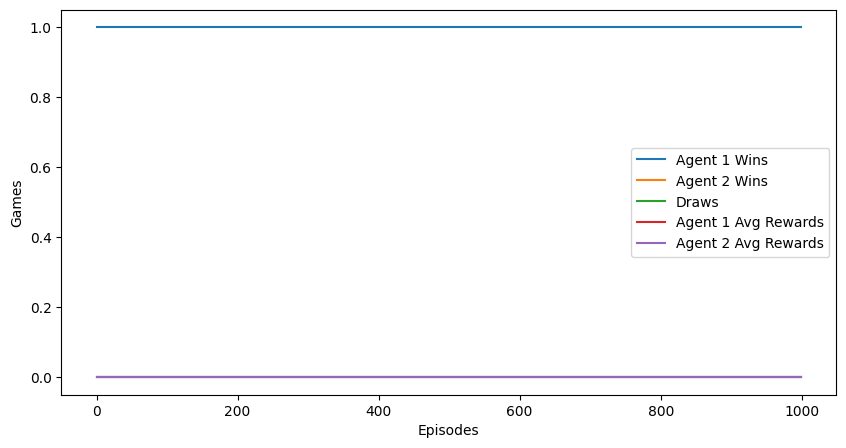

In [33]:
plot_metrics(metrics)

In [10]:
def save_model(agent, path):
    torch.save({
        'model_state_dict': agent.model.state_dict(),
        'target_model_state_dict': agent.target_model.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'epsilon': agent.epsilon
    }, path)
    print(f"Model saved at {path}")


def load_model(agent, path):
    checkpoint = torch.load(path)
    agent.model.load_state_dict(checkpoint['model_state_dict'])
    agent.target_model.load_state_dict(checkpoint['target_model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.epsilon = checkpoint['epsilon']
    print(f"Model loaded from {path}")

In [18]:
class Connect4UI:
    def __init__(self, model_p1, model_p2, ai_player=-1):
        # Initialize the game environment
        self.env = Connect4Env()
        self.model_p1 = model_p1  # Model for player 1 (X)
        self.model_p2 = model_p2  # Model for player -1 (O)
        self.ai_player = ai_player  # -1 means AI plays as O, 1 means AI plays as X
        self.model = self.model_p2 if ai_player == -1 else self.model_p1  # Current model

        # Create UI elements
        self.create_ui()

        # Set correct initial state
        self.initialize_game_state()

    def initialize_game_state(self):
        """Initialize the game state based on who starts first"""
        # Reset game
        self.state = self.env.reset()
        self.done = False

        # Update display
        self.update_display()

        # If AI goes first, make its move
        if self.env.current_player == self.ai_player:
            time.sleep(0.5)
            self.make_ai_move()

    def create_ui(self):
        # Title
        self.title = widgets.HTML(value="<h1 style='text-align: center;'>Connect 4</h1>")

        # Status message
        self.status = widgets.HTML(value="<h3 style='text-align: center;'>Game ready! Make your move</h3>")

        # Create buttons for each column
        self.buttons = []
        for col in range(7):
            btn = widgets.Button(description=str(col),
                                layout=widgets.Layout(width='60px', height='40px'))
            btn.on_click(lambda b, col=col: self.make_move(col))
            self.buttons.append(btn)

        # Button container (top row)
        self.button_container = widgets.HBox(self.buttons,
                                           layout=widgets.Layout(justify_content='center'))

        # Game board display
        self.board_display = widgets.HTML(value=self.render_board_html())

        # Add Read Board button
        self.read_board_button = widgets.Button(
            description="Read Board",
            button_style='info',
            layout=widgets.Layout(width='150px')
        )
        self.read_board_button.on_click(self.read_board_aloud)
        
        # Who starts selector
        self.player_options = [('You start (X)', 1), ('AI starts (O)', -1)]
        self.player_starter = widgets.RadioButtons(
            options=self.player_options,
            value=-1,  # Default to AI starting
            description='New Game:',
            layout=widgets.Layout(width='300px')
        )

        # New Game button
        self.new_game_button = widgets.Button(
            description="Start New Game",
            button_style='primary',
            layout=widgets.Layout(width='150px')
        )
        self.new_game_button.on_click(self.start_new_game)

        # Game controls
        self.game_controls = widgets.HBox([
            self.player_starter,
            self.new_game_button,
            self.read_board_button  # Add the Read Board button to the controls
        ], layout=widgets.Layout(justify_content='center', margin='20px 0'))

        # Add file upload widget for voice commands
        self.file_upload = widgets.FileUpload(
            accept='',  # Accept all file types
            multiple=False,  # Only allow single file upload
            description='Voice Command:',
            layout=widgets.Layout(width='250px')
        )
        self.file_upload.observe(self.handle_file_upload, names='value')

        # Add submit button for processing the uploaded file
        self.submit_button = widgets.Button(
            description="Process Command",
            button_style='success',
            layout=widgets.Layout(width='150px')
        )
        self.submit_button.on_click(self.process_audio_command)

        # Audio controls
        self.audio_controls = widgets.HBox([
            self.file_upload,
            self.submit_button
        ], layout=widgets.Layout(justify_content='center', margin='10px 0'))

        # Add upload status indicator
        self.upload_status = widgets.HTML(value="<p>No file uploaded</p>")

        # Add status for speech synthesis
        self.speech_status = widgets.HTML(value="")

        # Combine all widgets
        self.app = widgets.VBox([
            self.title,
            self.status,
            self.button_container,
            self.board_display,
            self.game_controls,
            self.audio_controls,
            self.upload_status,
            self.speech_status
        ], layout=widgets.Layout(width='100%', align_items='center'))

        # Display the UI
        display(self.app)
        
        # Add JavaScript for text-to-speech functionality
        display(HTML("""
        <script>
        function speakText(text) {
            if ('speechSynthesis' in window) {
                const utterance = new SpeechSynthesisUtterance(text);
                utterance.rate = 1.0;  // Speech rate
                utterance.pitch = 1.0; // Speech pitch
                window.speechSynthesis.cancel(); // Cancel any ongoing speech
                window.speechSynthesis.speak(utterance);
                return "Speaking...";
            } else {
                return "Text-to-speech not supported in this browser.";
            }
        }
        
        // Make the function available to Python
        window.speakText = speakText;
        </script>
        """))

    def read_board_aloud(self, _=None):
        """Convert board state to spoken text and read it aloud"""
        board_text = self.generate_board_description()
        
        # Use JavaScript to speak the text
        js_code = f"""
        var result = "";
        if (typeof window.speakText === 'function') {{
            result = window.speakText("{board_text}");
        }} else {{
            result = "Text-to-speech function not available.";
        }}
        result;
        """
        
        # Execute the JavaScript to speak the text
        try:
            from IPython.display import Javascript
            display(Javascript(js_code))
            self.speech_status.value = "<p>Reading board state aloud...</p>"
            
            # Clear the status after 3 seconds
            def clear_status():
                time.sleep(3)
                self.speech_status.value = ""
            
            import threading
            threading.Thread(target=clear_status).start()
            
        except Exception as e:
            self.speech_status.value = f"<p style='color:red;'>Error with text-to-speech: {str(e)}</p>"

    def generate_board_description(self):
        """Generate a textual description of the board state"""
        # Escape quotes for JavaScript
        board = self.env.board
        rows, cols = board.shape
        
        # Start with the game status
        if hasattr(self, 'done') and self.done:
            if self._check_winner(1):
                winner = 1
            elif self._check_winner(-1):
                winner = -1
            else:
                winner = 0
                
            if winner == 1:
                status = "Player X has won. " if self.ai_player == -1 else "AI has won. "
            elif winner == -1:
                status = "AI has won. " if self.ai_player == -1 else "Player X has won. "
            else:
                status = "The game is a draw. "
        else:
            human_player = -self.ai_player
            if self.env.current_player == human_player:
                player_name = "Your"
                player_symbol = "X" if human_player == 1 else "O"
            else:
                player_name = "AI's"
                player_symbol = "X" if self.ai_player == 1 else "O"
                
            status = f"It is {player_name} turn with {player_symbol}. "
        
        # Describe the board
        board_desc = "Board state: "
        
        # Count pieces by column
        for col in range(cols):
            pieces = []
            for row in range(rows-1, -1, -1):  # Start from bottom row
                if board[row, col] == 1:
                    pieces.append("X")
                elif board[row, col] == -1:
                    pieces.append("O")
            
            if pieces:
                board_desc += f"Column {col} has {len(pieces)} pieces: {', '.join(pieces)} from bottom to top. "
            else:
                board_desc += f"Column {col} is empty. "
        
        # Escape quotes and special characters
        full_description = status + board_desc
        full_description = full_description.replace('"', '\\"').replace("'", "\\'")
        
        return full_description

    def handle_file_upload(self, change):
        """Handle file upload event"""
        if change['new']:
            try:
                # Check if change['new'] is a tuple or a dictionary
                if isinstance(change['new'], tuple):
                    # If it's a tuple, extract the first element
                    uploaded_file = change['new'][0]
                else:
                    # If it's a dictionary, use the original code
                    uploaded_file = next(iter(change['new'].values()))
                
                # Check if 'metadata' exists in the structure
                if 'metadata' in uploaded_file and 'name' in uploaded_file['metadata']:
                    filename = uploaded_file['metadata']['name']
                    # Just acknowledge the upload
                    self.upload_status.value = f"<p>File uploaded: {filename}</p>"
                else:
                    # Handle case where metadata or name is missing
                    self.upload_status.value = f"<p>File uploaded successfully</p>"
                
                self.upload_status.value += f"<p>Click 'Process Command' to execute the command.</p>"
            except Exception as e:
                # Fallback for any unexpected structure
                self.upload_status.value = f"<p>File uploaded, but couldn't read file details: {str(e)}</p>"
                self.upload_status.value += f"<p>Click 'Process Command' to execute the command.</p>"

    def process_audio_command(self, _=None):
        """Process an uploaded audio file and dispatch the spoken command."""
        try:
            # ── 1. Validate upload ────────────────────────────────────────────────
            if not self.file_upload.value:
                self.upload_status.value = (
                    "<p style='color:orange;'>Please upload an audio file first.</p>"
                )
                return

            try:
                # Check if file_upload.value is a tuple or a dictionary
                if isinstance(self.file_upload.value, tuple):
                    # If it's a tuple, extract the first element
                    uploaded = self.file_upload.value[0]
                else:
                    # If it's a dictionary, use the original code
                    uploaded = next(iter(self.file_upload.value.values()))
                
                # Check if 'content' exists
                if 'content' not in uploaded:
                    self.upload_status.value = (
                        "<p style='color:red;'>Invalid file format: missing content</p>"
                    )
                    return
                    
                raw_bytes = uploaded["content"]
                
                # Try to get filename but provide default if not available
                fname = "uploaded_audio"
                if 'metadata' in uploaded and 'name' in uploaded['metadata']:
                    fname = uploaded['metadata']['name']
            except Exception as e:
                self.upload_status.value = (
                    f"<p style='color:red;'>Error reading file: {str(e)}</p>"
                )
                return

            self.upload_status.value = "<p style='color:blue;'>Processing audio file...</p>"

            # You need to import these libraries in your notebook
            # If these imports are failing, install the libraries first:
            # !pip install SpeechRecognition pydub
            try:
                import speech_recognition as sr
                from pydub import AudioSegment
            except ImportError as e:
                self.upload_status.value = (
                    "<p style='color:red;'>Missing required Python libraries. Please run the following in a cell:</p>"
                    "<pre>!pip install SpeechRecognition pydub</pre>"
                )
                return

            # ── 2. Convert to mono-WAV in-memory (handles mp3, wav, m4a, etc.) ────
            try:
                # This will fail if ffmpeg/ffprobe is not installed
                audio = AudioSegment.from_file(io.BytesIO(raw_bytes))
                audio = audio.set_frame_rate(16_000).set_channels(1)
                with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as wav_tmp:
                    audio.export(wav_tmp.name, format="wav")
                    wav_path = wav_tmp.name
            except FileNotFoundError as err:
                if 'ffprobe' in str(err) or 'ffmpeg' in str(err):
                    self.upload_status.value = (
                        "<p style='color:red;'>Missing FFmpeg tools. This feature requires FFmpeg to be installed.</p>"
                        "<p>Please install FFmpeg by running the following command in a cell:</p>"
                        "<pre>!apt-get update && apt-get install -y ffmpeg</pre>"
                        "<p>If using Google Colab, run:</p>"
                        "<pre>!apt-get update && apt-get install -y ffmpeg</pre>"
                        "<p>If using a local environment, install FFmpeg using your package manager, e.g.:</p>"
                        "<p>- Ubuntu/Debian: <code>sudo apt install ffmpeg</code></p>"
                        "<p>- macOS: <code>brew install ffmpeg</code></p>"
                        "<p>- Windows: <a href='https://ffmpeg.org/download.html'>Download from ffmpeg.org</a></p>"
                    )
                else:
                    self.upload_status.value = (
                        f"<p style='color:red;'>Error: {str(err)}</p>"
                    )
                return
            except Exception as exc:
                self.upload_status.value = (
                    "<p style='color:red;'>Cannot process audio \"" + fname + "\": " + str(exc) + "</p>"
                )
                return

            # ── 3. Speech-to-text (Google Web API) ────────────────────────────────
            try:
                recog = sr.Recognizer()
                with sr.AudioFile(wav_path) as source:
                    # remove ambient-noise adjustment for prerecorded files
                    audio_data = recog.record(source)      # grab the whole file
                text = recog.recognize_google(audio_data, language='en-US').lower()
                self.upload_status.value = f"<p>Heard: \"{text}\"</p>"
            except sr.UnknownValueError:
                self.upload_status.value = (
                    "<p style='color:red;'>Sorry, I couldn't understand that.</p>"
                )
                return
            except sr.RequestError as exc:
                self.upload_status.value = (
                    "<p style='color:red;'>Speech-service error: " + str(exc) + "</p>"
                )
                return
            finally:
                # Clean temp file
                with suppress(FileNotFoundError):
                    os.remove(wav_path)

            # ── 4. Command routing ────────────────────────────────────────────────
            digit_words = {
                "zero": 0,
                "one": 1,
                "two": 2,
                "three": 3,
                "four": 4,
                "five": 5,
                "six": 6,
            }

            # Add handling for "read board" command
            if re.search(r"\bread\b.*\bboard\b", text):
                self.upload_status.value += "<p>Reading board state...</p>"
                self.read_board_aloud(None)
                return

            # new-game
            if re.search(r"\bnew\b.*\bgame\b", text):
                self.upload_status.value += "<p>Starting a new game!</p>"
                self.start_new_game(None)
                return

            # column n / just n
            # 1️⃣ match "column three", "col 3", "place in five" …
            col_match = re.search(r"\b(col(?:umn)?|place(?:\sin)?)\s*(\w+)", text)
            word_or_digit = None
            if col_match:
                word_or_digit = col_match.group(2)
            else:
                # 2️⃣ plain "three" / "3"
                word_or_digit = text.strip()

            # map to integer 0-6
            if word_or_digit in digit_words:
                col = digit_words[word_or_digit]
            elif word_or_digit.isdigit() and 0 <= int(word_or_digit) <= 6:
                col = int(word_or_digit)
            else:
                self.upload_status.value += (
                    "<p style='color:orange;'>Command not recognized. "
                    "Say e.g. \"column three\", \"new game\", or \"read board\".</p>"
                )
                return

            # ── 5. Execute move ───────────────────────────────────────────────────
            self.upload_status.value += f"<p>Placing piece in column {col}</p>"
            self.make_move(col)

            # ── 6. Reset uploader for next use ────────────────────────────────────
            try:
                if isinstance(self.file_upload.value, tuple):
                    self.file_upload.value = ()  # Clear tuple
                else:
                    self.file_upload.value.clear()  # Clear dictionary
            except Exception as e:
                # Just ignore errors in clearing
                pass

        except ImportError as e:
            self.upload_status.value = (
                "<p style='color:red;'>Missing required libraries: " + str(e) + ". "
                "Please install the required libraries using !pip install.</p>"
            )
        except Exception as e:
            self.upload_status.value = (
                "<p style='color:red;'>Error processing audio: " + str(e) + "</p>"
            )

    def start_new_game(self, b):
        """Start a new game with the selected starting player"""
        # Get who starts from the radio buttons
        selected_value = self.player_starter.value

        # Figure out who the AI player is based on selected value
        self.ai_player = -selected_value
        
        # Assign the right model based on which player the AI is
        self.model = self.model_p2 if self.ai_player == -1 else self.model_p1
        
        # Reset the game
        self.state = self.env.reset()
        self.done = False

        # Re-enable buttons
        for btn in self.buttons:
            btn.disabled = False

        # Update the display
        self.update_display()

        # If AI goes first, make its move
        if self.env.current_player == self.ai_player:
            time.sleep(0.5)
            self.make_ai_move()

    def render_board_html(self):
        """Render the Connect 4 board as HTML for display"""
        html = """
        <style>
        .board {
            background-color: #0052cc;
            display: inline-block;
            padding: 10px;
            border-radius: 10px;
        }
        .cell {
            width: 60px;
            height: 60px;
            background-color: #ffffff;
            border-radius: 50%;
            display: inline-block;
            margin: 5px;
        }
        .player1 {
            background-color: #ff0000;
        }
        .player-1 {
            background-color: #ffff00;
        }
        </style>
        <div class="board">
        """

        # Render each cell
        for row in range(self.env.rows):
            html += "<div>"
            for col in range(self.env.cols):
                cell_value = self.env.board[row, col]
                cell_class = f"cell player{cell_value}" if cell_value != 0 else "cell"
                html += f'<div class="{cell_class}"></div>'
            html += "</div>"

        html += "</div>"
        return html

    def update_display(self):
        """Update the board display and status message"""
        self.board_display.value = self.render_board_html()

        # Check game status
        reward = 0
        if hasattr(self, 'done') and self.done:
            # Game is over
            if self._check_winner(1):
                winner = 1
            elif self._check_winner(-1):
                winner = -1
            else:
                winner = 0  # Draw

            if winner == 1:
                message = "You win! 🎉" if self.ai_player == -1 else "AI wins! 🤖"
                color = "green" if self.ai_player == -1 else "red"
            elif winner == -1:
                message = "AI wins! 🤖" if self.ai_player == -1 else "You win! 🎉"
                color = "red" if self.ai_player == -1 else "green"
            else:
                message = "Draw game! 🤝"
                color = "blue"

            self.status.value = f"<h3 style='text-align: center; color: {color};'>{message}</h3>"

            # Disable column buttons
            for btn in self.buttons:
                btn.disabled = True
        else:
            # Game is ongoing
            current_player = self.env.current_player
            human_player = -self.ai_player

            if current_player == human_player:
                player_name = "Your"
                player_symbol = "(X)" if human_player == 1 else "(O)"
            else:
                player_name = "AI's"
                player_symbol = "(X)" if self.ai_player == 1 else "(O)"

            self.status.value = f"<h3 style='text-align: center;'>{player_name} turn {player_symbol}</h3>"

    def make_move(self, column):
        """Handle player's move on column click"""
        if hasattr(self, 'done') and self.done:
            # Game is already over
            return

        # Determine if it's human's turn
        human_player = -self.ai_player
        if self.env.current_player != human_player:
            self.status.value = "<h3 style='text-align: center; color: orange;'>Not your turn!</h3>"
            return

        # Check if move is valid
        if column not in self.env.available_moves():
            self.status.value = "<h3 style='text-align: center; color: orange;'>Invalid move! Column is full</h3>"
            return

        # Make the move
        next_state, reward, done, _ = self.env.step(column)
        self.state = next_state
        self.done = done

        # Update the display
        self.update_display()

        # If game not over and AI's turn, make AI move
        if not done and self.env.current_player == self.ai_player:
            # Add a small delay for better UX
            time.sleep(0.5)
            self.make_ai_move()

    def make_ai_move(self):
        """Make an AI move using the trained model"""
        if hasattr(self, 'done') and self.done:
            return

        # Use select_action from the RL code
        valid_actions = self.env.available_moves()
        action = select_action(self.model, self.state, epsilon=0.0, valid_actions=valid_actions)

        # Make the move
        next_state, reward, done, _ = self.env.step(action)
        self.state = next_state
        self.done = done

        # ✅ Update display to reflect the AI move
        self.update_display()

        # ✅ If the game is not done, switch back to the player
        if not done:
            self.env.switch_player()
            self.update_display()

    def _check_winner(self, player):
        """Check if given player has won by having 4 in a row anywhere on the board"""
        # Can only win if player is 1 (X) or -1 (O)
        if player == 0:
            return False
            
        board = self.env.board
        rows, cols = board.shape
    
        # Horizontal check
        for r in range(rows):
            for c in range(cols - 3):
                if (board[r, c] == player and 
                    board[r, c+1] == player and 
                    board[r, c+2] == player and 
                    board[r, c+3] == player):
                    return True
        
        # Vertical check
        for r in range(rows - 3):
            for c in range(cols):
                if (board[r, c] == player and 
                    board[r+1, c] == player and 
                    board[r+2, c] == player and 
                    board[r+3, c] == player):
                    return True
        
        # Diagonal down-right
        for r in range(rows - 3):
            for c in range(cols - 3):
                if (board[r, c] == player and 
                    board[r+1, c+1] == player and 
                    board[r+2, c+2] == player and 
                    board[r+3, c+3] == player):
                    return True
        
        # Diagonal up-right
        for r in range(3, rows):
            for c in range(cols - 3):
                if (board[r, c] == player and 
                    board[r-1, c+1] == player and 
                    board[r-2, c+2] == player and 
                    board[r-3, c+3] == player):
                    return True
        
        return False 
    
# Function to start the UI with a trained model
def start_connect4_ui(model_p1, model_p2, ai_player=-1):
    """
    Start the Connect4 UI with the trained model

    Args:
        model: The trained DQN model
        ai_starts: True if AI should start the game, False otherwise
    """
    ui = Connect4UI(model_p1, model_p2, ai_player=ai_player)
    return ui

In [12]:
def start_connect4_ui(model_p1, model_p2, ai_player=-1):
    from Connect4UI import Connect4UI
    ui = Connect4UI(model_p1, model_p2, ai_player=ai_player)
    return ui

Episode 0/1000 - Agent 1 Wins: 0, Agent 2 Wins: 0, Draws: 0
Episode 100/1000 - Agent 1 Wins: 0, Agent 2 Wins: 0, Draws: 0
Episode 200/1000 - Agent 1 Wins: 0, Agent 2 Wins: 0, Draws: 0
Episode 300/1000 - Agent 1 Wins: 0, Agent 2 Wins: 0, Draws: 0
Episode 400/1000 - Agent 1 Wins: 0, Agent 2 Wins: 0, Draws: 0
Episode 500/1000 - Agent 1 Wins: 0, Agent 2 Wins: 0, Draws: 0
Episode 600/1000 - Agent 1 Wins: 0, Agent 2 Wins: 0, Draws: 0


In [17]:
env = Connect4Env()

# Create models for the agents
model1 = DQN(input_dim=ROWS * COLS, output_dim=COLS)
model2 = DQN(input_dim=ROWS * COLS, output_dim=COLS)

# Create target models
target_model1 = DQN(input_dim=ROWS * COLS, output_dim=COLS)
target_model2 = DQN(input_dim=ROWS * COLS, output_dim=COLS)

# Create memory
memory1 = ReplayMemory(capacity=10000)
memory2 = ReplayMemory(capacity=10000)

# Create the agents
agent1 = DQNAgent(env, model1, target_model1, memory1)
agent2 = DQNAgent(env, model2, target_model2, memory2)

# ✅ Now load the model into the agent
load_model(agent1, "agent1_final.pth")
load_model(agent2, "agent2_final.pth")

start_connect4_ui(agent1.model, agent2.model, ai_player=-1)

Model loaded from agent1_final.pth
Model loaded from agent2_final.pth


C:\Users\ajmat\AppData\Local\Temp\ipykernel_121816\3630779548.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)
